# Bishop Basement Model

## Import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging

import harmonica as hm
import numpy as np
import pandas as pd
import pooch
import verde as vd
import xarray as xr
from polartoolkit import maps
from polartoolkit import utils as polar_utils

from invert4geom import (
    cross_validation,
    inversion,
    plotting,
    regional,
    utils,
)

# Get data

Here we will load a commonly used synthetic gravity and basement topography model. It includes topography of the Moho and the sediment-basement contact, and the forward modelled gravity effect of each, providing a synthetic observed gravity dataset.

In [2]:
# from https://wiki.seg.org/wiki/Bishop_Model

url = "https://drive.usercontent.google.com/download?id=0B_notXWcvuh8dGZWbHlGODRMWEE&export=download&authuser=0&confirm=t&uuid=5d6bd6a1-a14b-48b6-ac76-6eda9f1baf1d&at=APZUnTVqVzwqlXHZAiYK-RoxHsH6%3A1713697379614"
fname = "bishop_Geosoft_grids.tar.gz"
known_hash = None
path = pooch.retrieve(
    url=url,
    fname=fname,
    path=pooch.os_cache("bishop"),
    known_hash=known_hash,
    progressbar=True,
    processor=pooch.Untar(extract_dir=pooch.os_cache("bishop")),
)
geosoft_grids = [p for p in path if (p.endswith((".grd", ".GRD")))]
geosoft_grids

['/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_20000_i0.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_moho_i30.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_30000_i45.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_20000_i30.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_15000_i0.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_moho.GRD',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_15000_i60.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_susceptibility.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_20000_i90.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_gravity.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_15000_i30.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_basement.grd',
 '/home/mdtanker/.cache/bishop/Geosoft_grids/bishop5x_mag_base_20000_i60.grd',
 '/home/mdtanke

In [3]:
# get the necessary file paths
basement_path = [p for p in geosoft_grids if p.endswith("bishop5x_basement.grd")][0]  # noqa: RUF015
gravity_path = [p for p in geosoft_grids if p.endswith("bishop5x_gravity.grd")][0]  # noqa: RUF015
moho_path = [p for p in geosoft_grids if p.endswith("bishop5x_moho.GRD")][0]  # noqa: RUF015

In [4]:
# convert the .grd into xarray data arrays
basement = hm.load_oasis_montaj_grid(basement_path)
gravity = hm.load_oasis_montaj_grid(gravity_path)
moho = hm.load_oasis_montaj_grid(moho_path)

# merge into a dataset
data_full_res = xr.Dataset(
    {
        "basement": basement,
        "gravity": gravity,
        "moho": moho,
    }
)
data_full_res

<xarray.Dataset> Size: 92MB
Dimensions:   (easting: 1901, northing: 2011)
Coordinates:
  * easting   (easting) float64 15kB 2e+03 2.2e+03 ... 3.818e+05 3.82e+05
  * northing  (northing) float64 16kB 1.41e+05 1.412e+05 ... 5.428e+05 5.43e+05
Data variables:
    basement  (northing, easting) float64 31MB -6.068e+03 ... -8.099e+03
    gravity   (northing, easting) float64 31MB 99.3 99.29 99.28 ... 106.7 106.7
    moho      (northing, easting) float64 31MB -2.781e+04 ... -2.553e+04

In [5]:
# resample to low resolution for testing purposes
data = data_full_res.coarsen(easting=40, northing=40, boundary="trim").mean()
data

<xarray.Dataset> Size: 57kB
Dimensions:   (northing: 50, easting: 47)
Coordinates:
  * easting   (easting) float64 376B 5.9e+03 1.39e+04 ... 3.659e+05 3.739e+05
  * northing  (northing) float64 400B 1.449e+05 1.529e+05 ... 5.369e+05
Data variables:
    basement  (northing, easting) float64 19kB -6.176e+03 ... -8.115e+03
    gravity   (northing, easting) float64 19kB 99.12 99.11 99.83 ... 108.5 107.5
    moho      (northing, easting) float64 19kB -2.77e+04 ... -2.553e+04

# Define model domain parameters
To account for edge effects (decreasing gravity towards the edge of prism model), we will use a buffer region and a smaller inversion region so the prism model edge is further away from the inversion domain.

In [6]:
buffer_region = vd.get_region(
    (data.basement.easting.values, data.basement.northing.values)
)
inversion_region = vd.pad_region(buffer_region, -64e3)
# inversion_region = buffer_region

grav_spacing = polar_utils.get_grid_info(data.gravity)[0]
topo_spacing = polar_utils.get_grid_info(data.basement)[0]
print(f"gravity spacing: {grav_spacing}m")
print(f"topography spacing: {topo_spacing}m")

gravity spacing: 8000.0m
topography spacing: 8000.0m


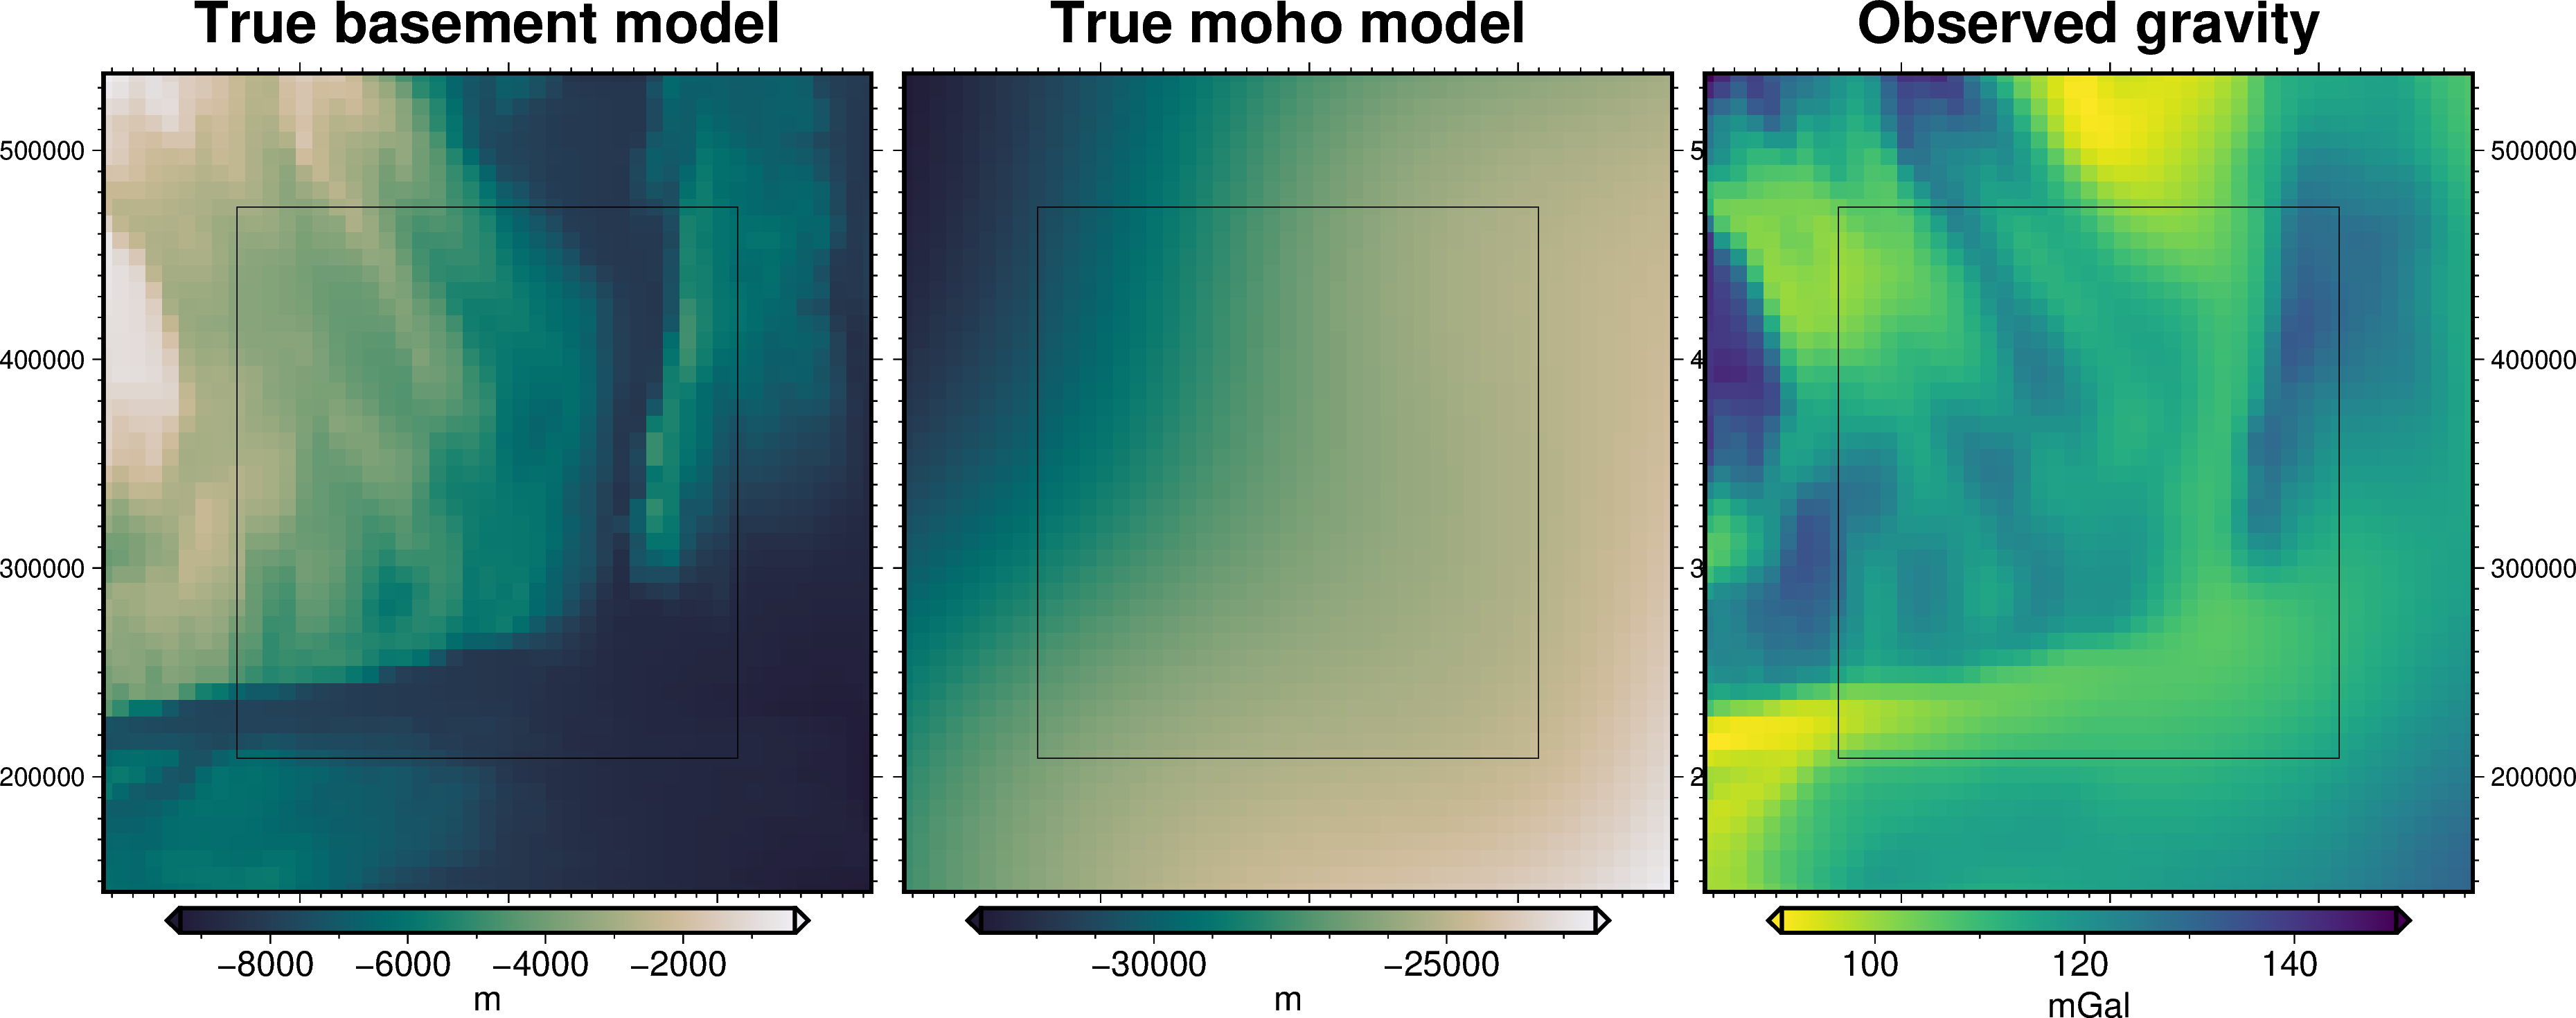

In [7]:
fig = maps.plot_grd(
    data.basement,
    fig_height=10,
    title="True basement model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig = maps.plot_grd(
    data.moho,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="True moho model",
    reverse_cpt=True,
    cmap="rain",
    cbar_label="m",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig = maps.plot_grd(
    data.gravity,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Observed gravity",
    reverse_cpt=True,
    cmap="viridis",
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
)

fig.show()

# Observed gravity data

In this scenario, we are treating the area as having no surface topography (surface elevation is flat and equal to the ellipsoid). In this case, there is no terrain mass effect, and therefore the gravity disturbance is equal to the topo-free disturbance.

In [8]:
# subset gravity to within inversion region
grav_grid = polar_utils.subset_grid(
    data.gravity,
    region=inversion_region,
)
grav_df = grav_grid.rename("topo_free_disturbance").to_dataframe().reset_index()
grav_df["upward"] = 10
grav_df

,northing,easting,topo_free_disturbance,upward
0,208900.0,69900.0,103.880277,10
1,208900.0,77900.0,105.855331,10
2,208900.0,85900.0,106.922902,10
3,208900.0,93900.0,107.239824,10
4,208900.0,101900.0,107.511401,10
...,...,...,...,...
1049,472900.0,277900.0,115.850334,10
1050,472900.0,285900.0,123.881323,10
1051,472900.0,293900.0,127.586472,10
1052,472900.0,301900.0,127.137761,10


## Calculate gravity effect of the Moho
This is already included in the "observed gravity" but we calculate it from the Moho topography in order to access the effectiveness of our regional seperation.

In [9]:
# pick a reference height for the moho
zref = data.moho.values.mean()

# pick a density contrast for the moho
density_contrast = 3300 - 2700

# prisms are created between zref and the height of the topography, which for this
# starting model is flat.
# prisms above zref have positive density contrast and prisms below zref have negative
# density contrast
density_grid = xr.where(data.moho >= zref, density_contrast, -density_contrast)

# create layer of prisms
moho_prisms = utils.grids_to_prisms(
    data.moho,
    zref,
    density=density_grid,
)

# calculate forward gravity of starting prism layer
grav_df["moho_grav"] = moho_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

  0%|          | 0/1054 [00:00<?, ?it/s]

In [10]:
# resample to half spacing
# Note that it is important to do this resampling on the original observed gravity data
# before you calculate your misfit!
grav_df = cross_validation.resample_with_test_points(
    grav_spacing, grav_df, inversion_region
)
grav_df

,northing,easting,test,topo_free_disturbance,upward,moho_grav
0,208900.0,69900.0,False,103.880280,10,1.169883
1,208900.0,73900.0,True,104.924523,10,2.394287
2,208900.0,77900.0,False,105.855331,10,3.613480
3,208900.0,81900.0,True,106.492752,10,4.821293
4,208900.0,85900.0,False,106.922905,10,6.015381
...,...,...,...,...,...,...
4082,472900.0,293900.0,False,127.586472,10,25.183226
4083,472900.0,297900.0,True,127.647337,10,25.792486
4084,472900.0,301900.0,False,127.137764,10,26.355160
4085,472900.0,305900.0,True,126.734184,10,26.858189


# Create "a-priori" basement measurements

In [11]:
# create 10 random point within the outcropping basement region
num_constraints = 15
coords = vd.scatter_points(
    region=vd.pad_region(inversion_region, -10e3),
    # region=inversion_region,
    size=num_constraints,
    random_state=22,
)
constraint_points = pd.DataFrame(data={"easting": coords[0], "northing": coords[1]})

# sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points, data.basement, "upward", coord_names=("easting", "northing")
)

# Create starting basement model

In [12]:
# grid the sampled values using verde
starting_topography = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=topo_spacing,
    constraints_df=constraint_points,
    dampings=[None, 1e-20],
    # dampings=np.logspace(-60, -5, 10),
)

# ensure starting model doesn't go above surface topography (which is a flat plane at 0)
starting_topography = xr.where(starting_topography > 0, 0, starting_topography)

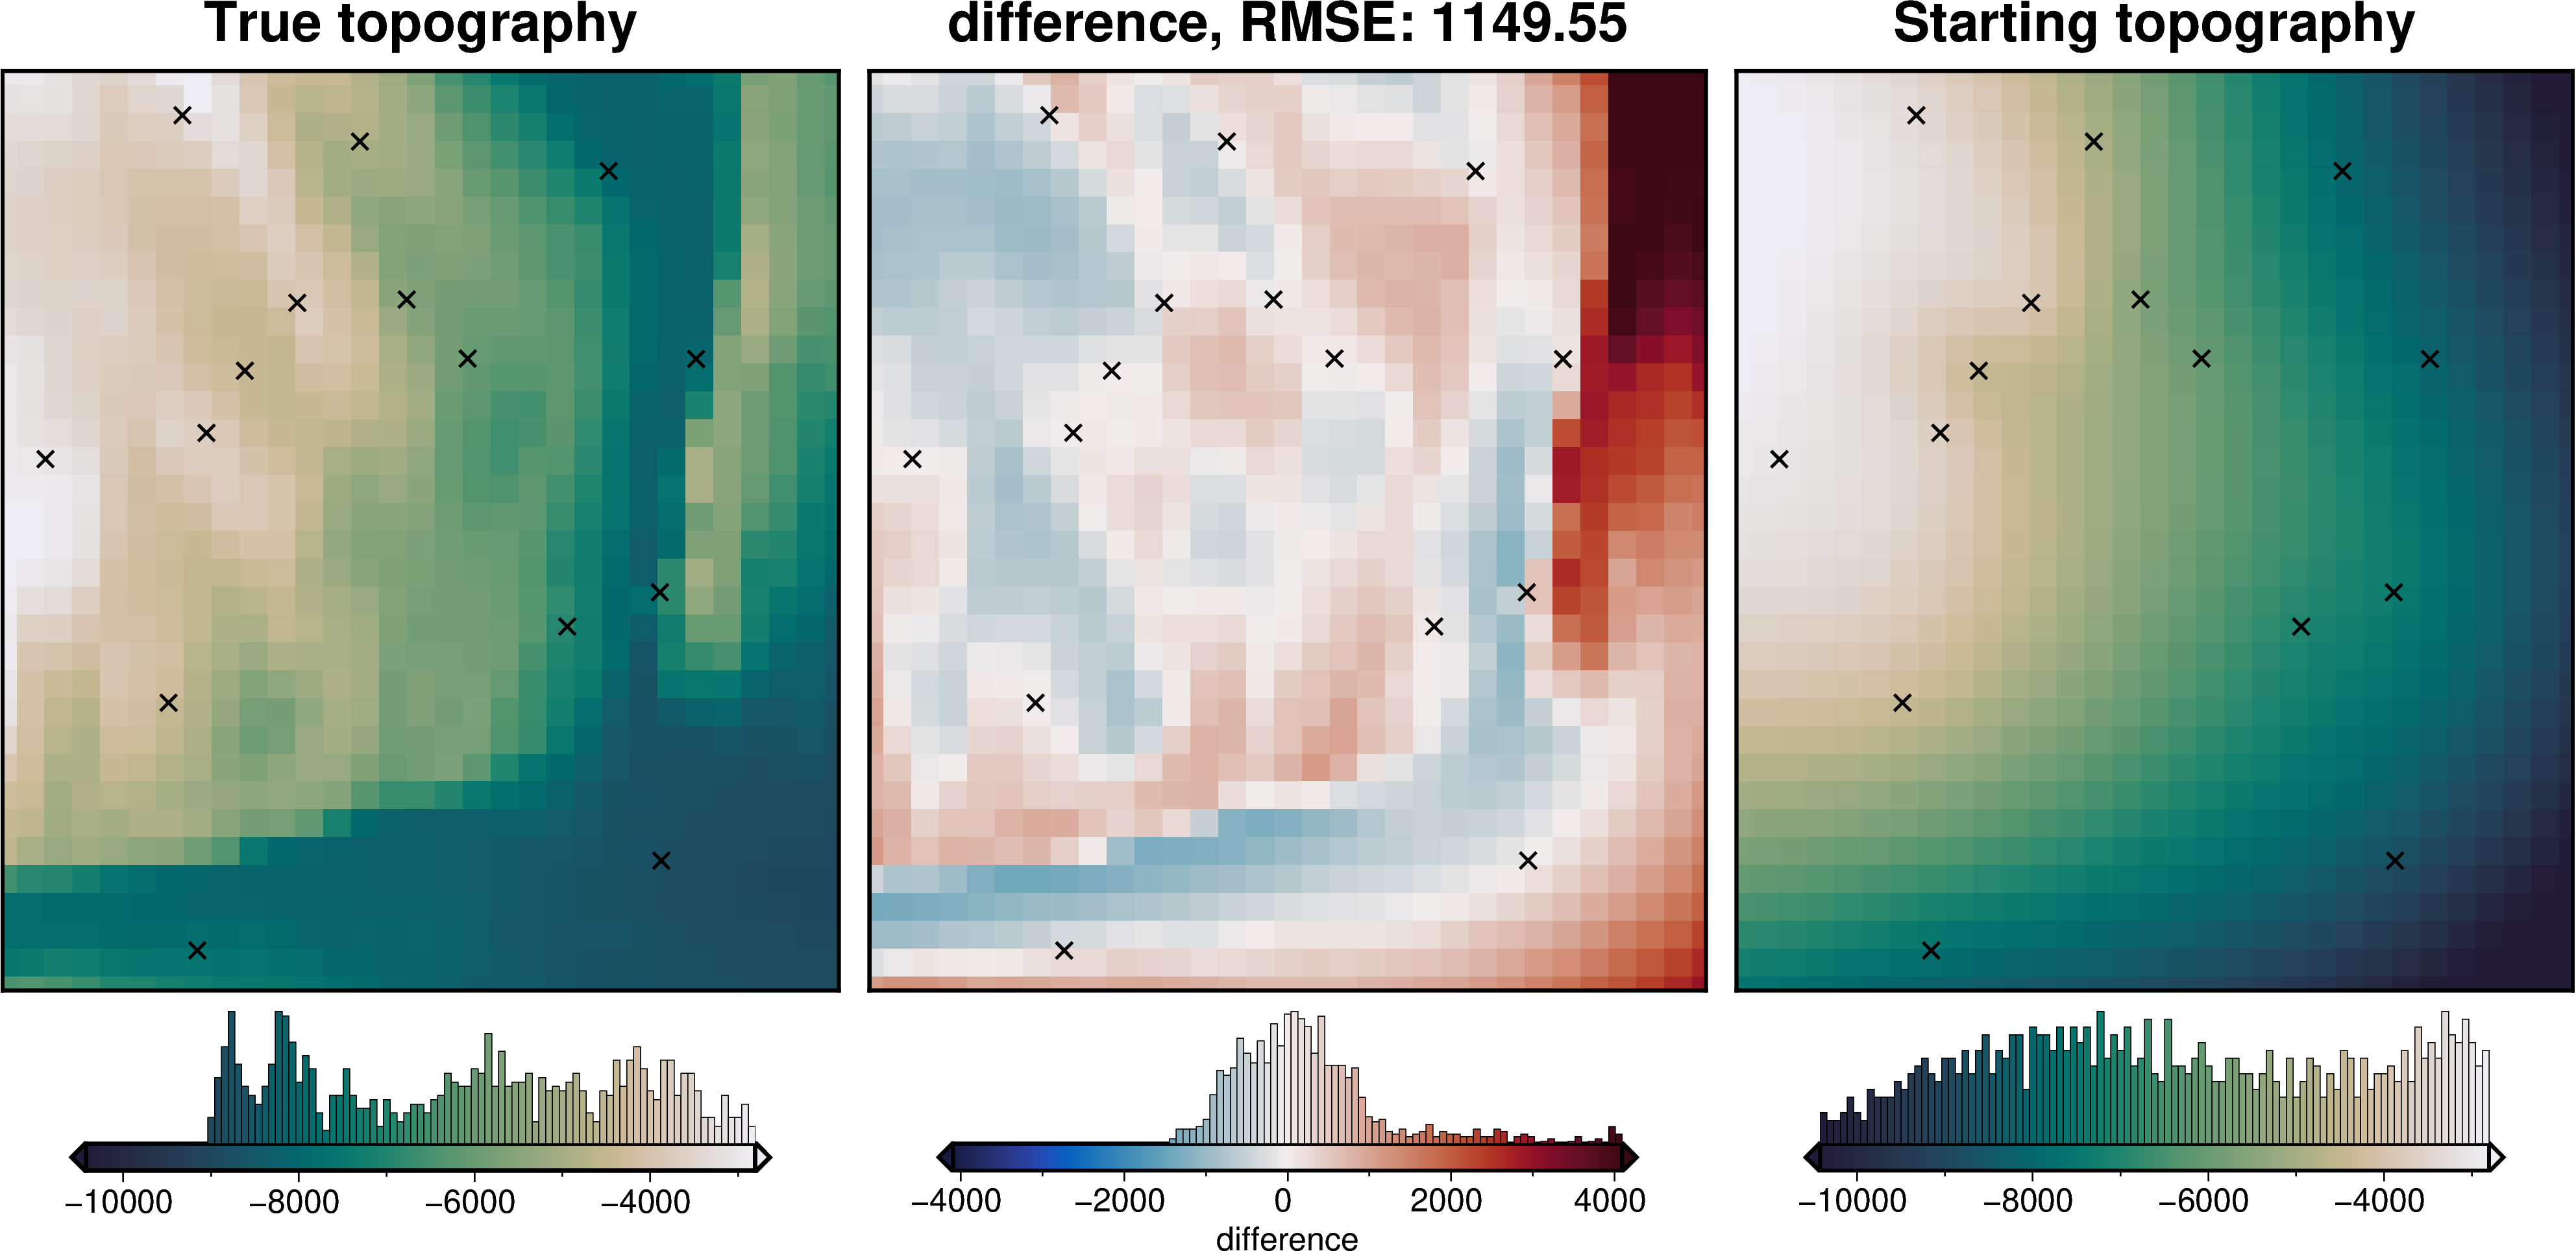

In [13]:
_ = polar_utils.grd_compare(
    data.basement,
    starting_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Starting topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.3c",
)

In [14]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    starting_topography,
    "starting_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.starting_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 10.10 m


zref: -5751.18 m


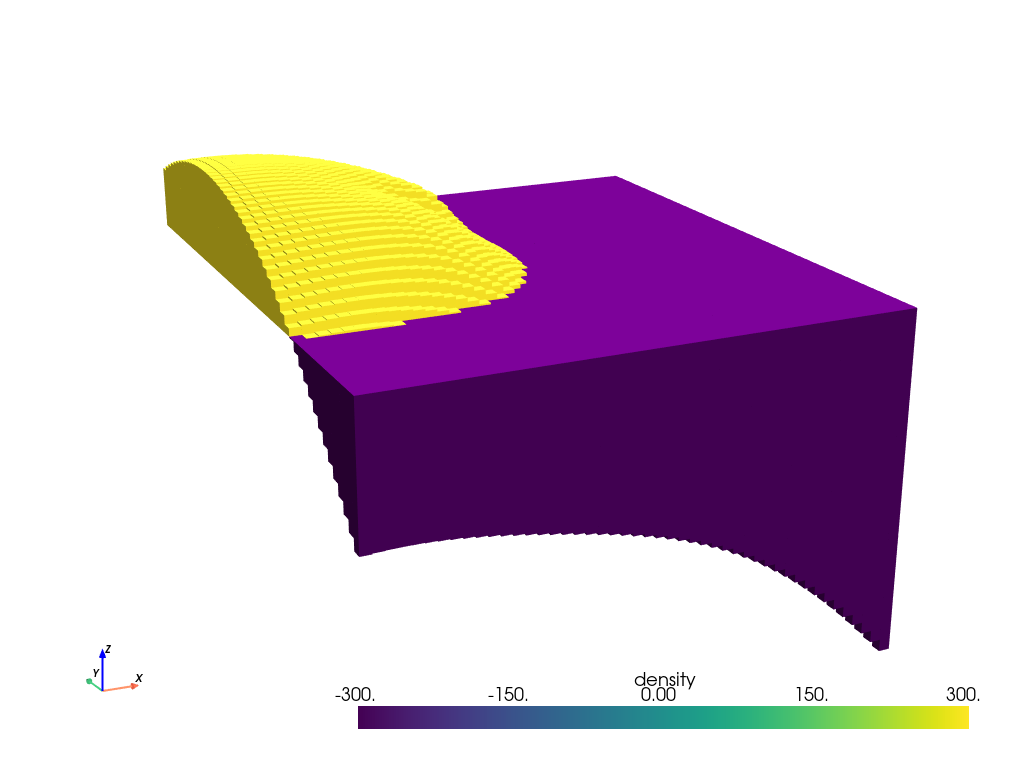

In [15]:
# pick a reference height for the basement
# zref = starting_topography.values.mean()
zref = constraint_points.upward.mean()
print(f"zref: {zref:.2f} m")

# pick a density contrast for the basement (crystalline basement - sedimentary rocks)
density_contrast = 2700 - 2400

density_grid = xr.where(
    starting_topography >= zref, density_contrast, -density_contrast
)

# create layer of prisms
starting_prisms = utils.grids_to_prisms(
    starting_topography,
    zref,
    density=density_grid,
)

plotting.show_prism_layers(
    starting_prisms,
    color_by="density",
    log_scale=False,
    zscale=20,
    backend="static",
)

# Gravity misfit

All inversions in Invert4Geom are based on a gravity misfit, not a gravity anomaly. This means before the inversion, we must create a starting prism model, forward model it's gravity effect, remove it from the gravity anomaly, and get a gravity misfit. 

However, if we know nothing about the starting model, it can simply be a flat layer of zero thickness, as we will use here. In this case, the forward gravity would just be zero so there is no need to perform the forward modelling. The misfit is therefore just equal to the topo-free disturbance.

### Forward gravity of starting prism layer

In [16]:
# calculate forward gravity of starting prism layer
grav_df["starting_grav"] = starting_prisms.prism_layer.gravity(
    coordinates=(
        grav_df.easting,
        grav_df.northing,
        grav_df.upward,
    ),
    field="g_z",
    progressbar=True,
)

# calculate misfit as observed - starting
grav_df["misfit"] = grav_df.topo_free_disturbance - grav_df.starting_grav

constraints_dampings = list(np.logspace(-20, -2, 20))
constraints_dampings.append(None)

# use the constraints to find the best regional field
grav_df = regional.regional_separation(
    grav_df=grav_df,
    grav_data_column="misfit",
    regional_column="reg",
    # method="eq_sources",
    # source_depth=-400e3,
    # block_size=grav_spacing * 6,
    method="constraints",
    constraints_df=constraint_points,
    dampings=constraints_dampings,
)

# remove the regional from the misfit to get the residual
grav_df["res"] = grav_df.misfit - grav_df.reg

grav_df

  0%|          | 0/4087 [00:00<?, ?it/s]

,northing,easting,test,topo_free_disturbance,upward,moho_grav,starting_grav,misfit,reg,res
0,208900.0,69900.0,False,103.880280,10,1.169883,-22.036595,125.916874,117.775246,8.141629
1,208900.0,73900.0,True,104.924523,10,2.394287,-22.426617,127.351140,118.801056,8.550084
2,208900.0,77900.0,False,105.855331,10,3.613480,-22.842449,128.697780,119.818588,8.879192
3,208900.0,81900.0,True,106.492752,10,4.821293,-23.284201,129.776953,120.827042,8.949911
4,208900.0,85900.0,False,106.922905,10,6.015381,-23.750189,130.673094,121.825500,8.847593
...,...,...,...,...,...,...,...,...,...,...
4082,472900.0,293900.0,False,127.586472,10,25.183226,-51.748620,179.335092,148.659317,30.675775
4083,472900.0,297900.0,True,127.647337,10,25.792486,-53.440799,181.088136,150.008163,31.079972
4084,472900.0,301900.0,False,127.137764,10,26.355160,-55.124636,182.262400,151.345917,30.916483
4085,472900.0,305900.0,True,126.734184,10,26.858189,-56.796897,183.531081,152.673141,30.857939


/home/mdtanker/polartoolkit/src/polartoolkit/maps.py:883: UserWarning: getting max/min values from grid, if cpt_lims were used to create the colorscale, histogram will not properly align with colorbar!
  add_colorbar(
/home/mdtanker/polartoolkit/src/polartoolkit/maps.py:883: UserWarning: getting max/min values from grid, if cpt_lims were used to create the colorscale, histogram will not properly align with colorbar!
  add_colorbar(


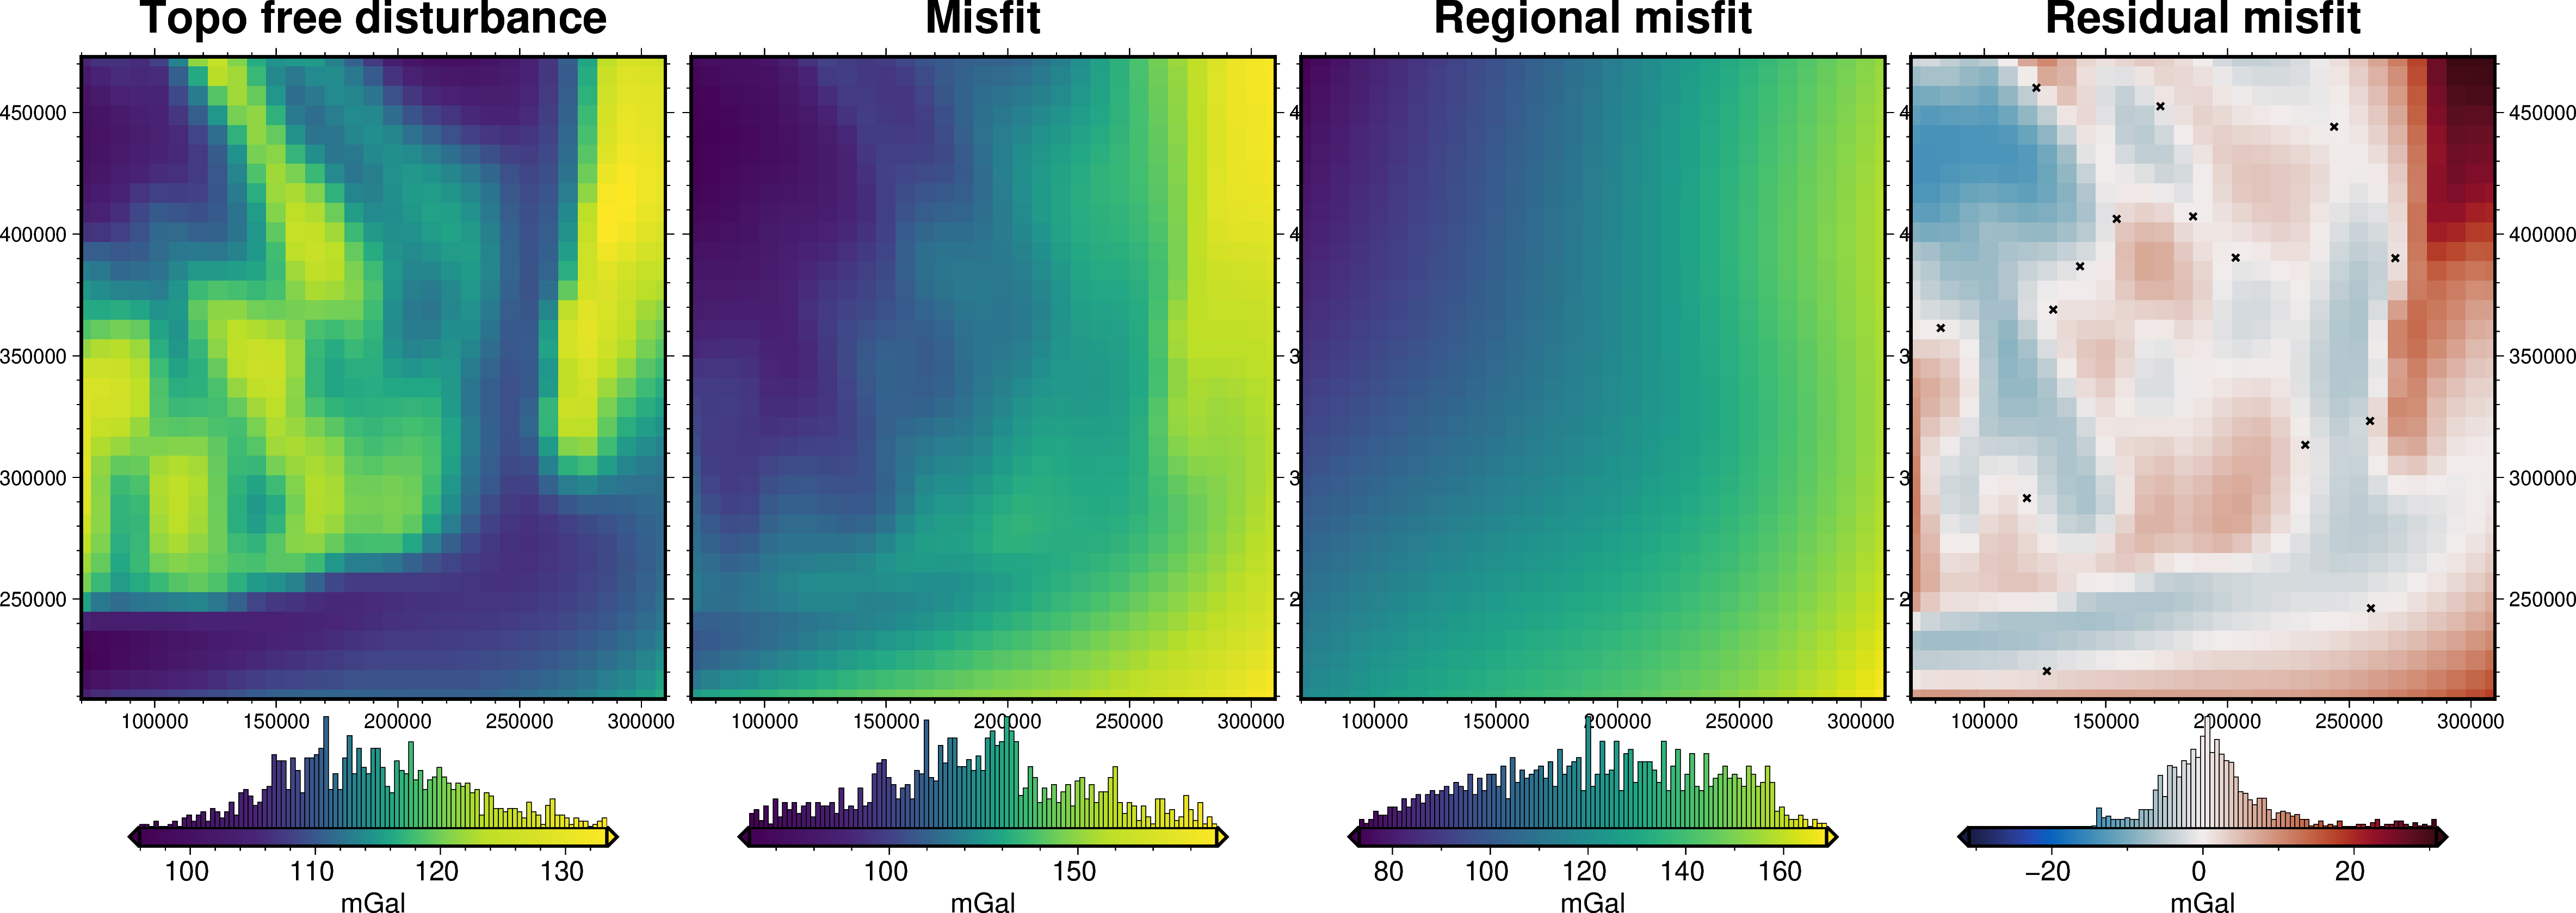

In [17]:
grav_grid = grav_df[~grav_df.test].set_index(["northing", "easting"]).to_xarray()

fig = maps.plot_grd(
    grav_grid.topo_free_disturbance,
    region=inversion_region,
    fig_height=10,
    title="Topo free disturbance",
    cmap="viridis",
    hist=True,
    grd2cpt=True,
    cbar_label="mGal",
    frame=["nSWe", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.misfit,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Misfit",
    cmap="viridis",
    hist=True,
    grd2cpt=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.reg,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Regional misfit",
    cmap="viridis",
    hist=True,
    # grd2cpt=True,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
)

fig = maps.plot_grd(
    grav_grid.res,
    region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    fig_height=10,
    title="Residual misfit",
    cmap="balance+h0",
    cpt_lims=[-vd.maxabs(grav_grid.res), vd.maxabs(grav_grid.res)],
    # cpt_lims=[-50, 50],
    hist=True,
    grd2cpt=False,
    cbar_label="mGal",
    frame=["nSwE", "xaf10000", "yaf10000"],
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)
fig.show()

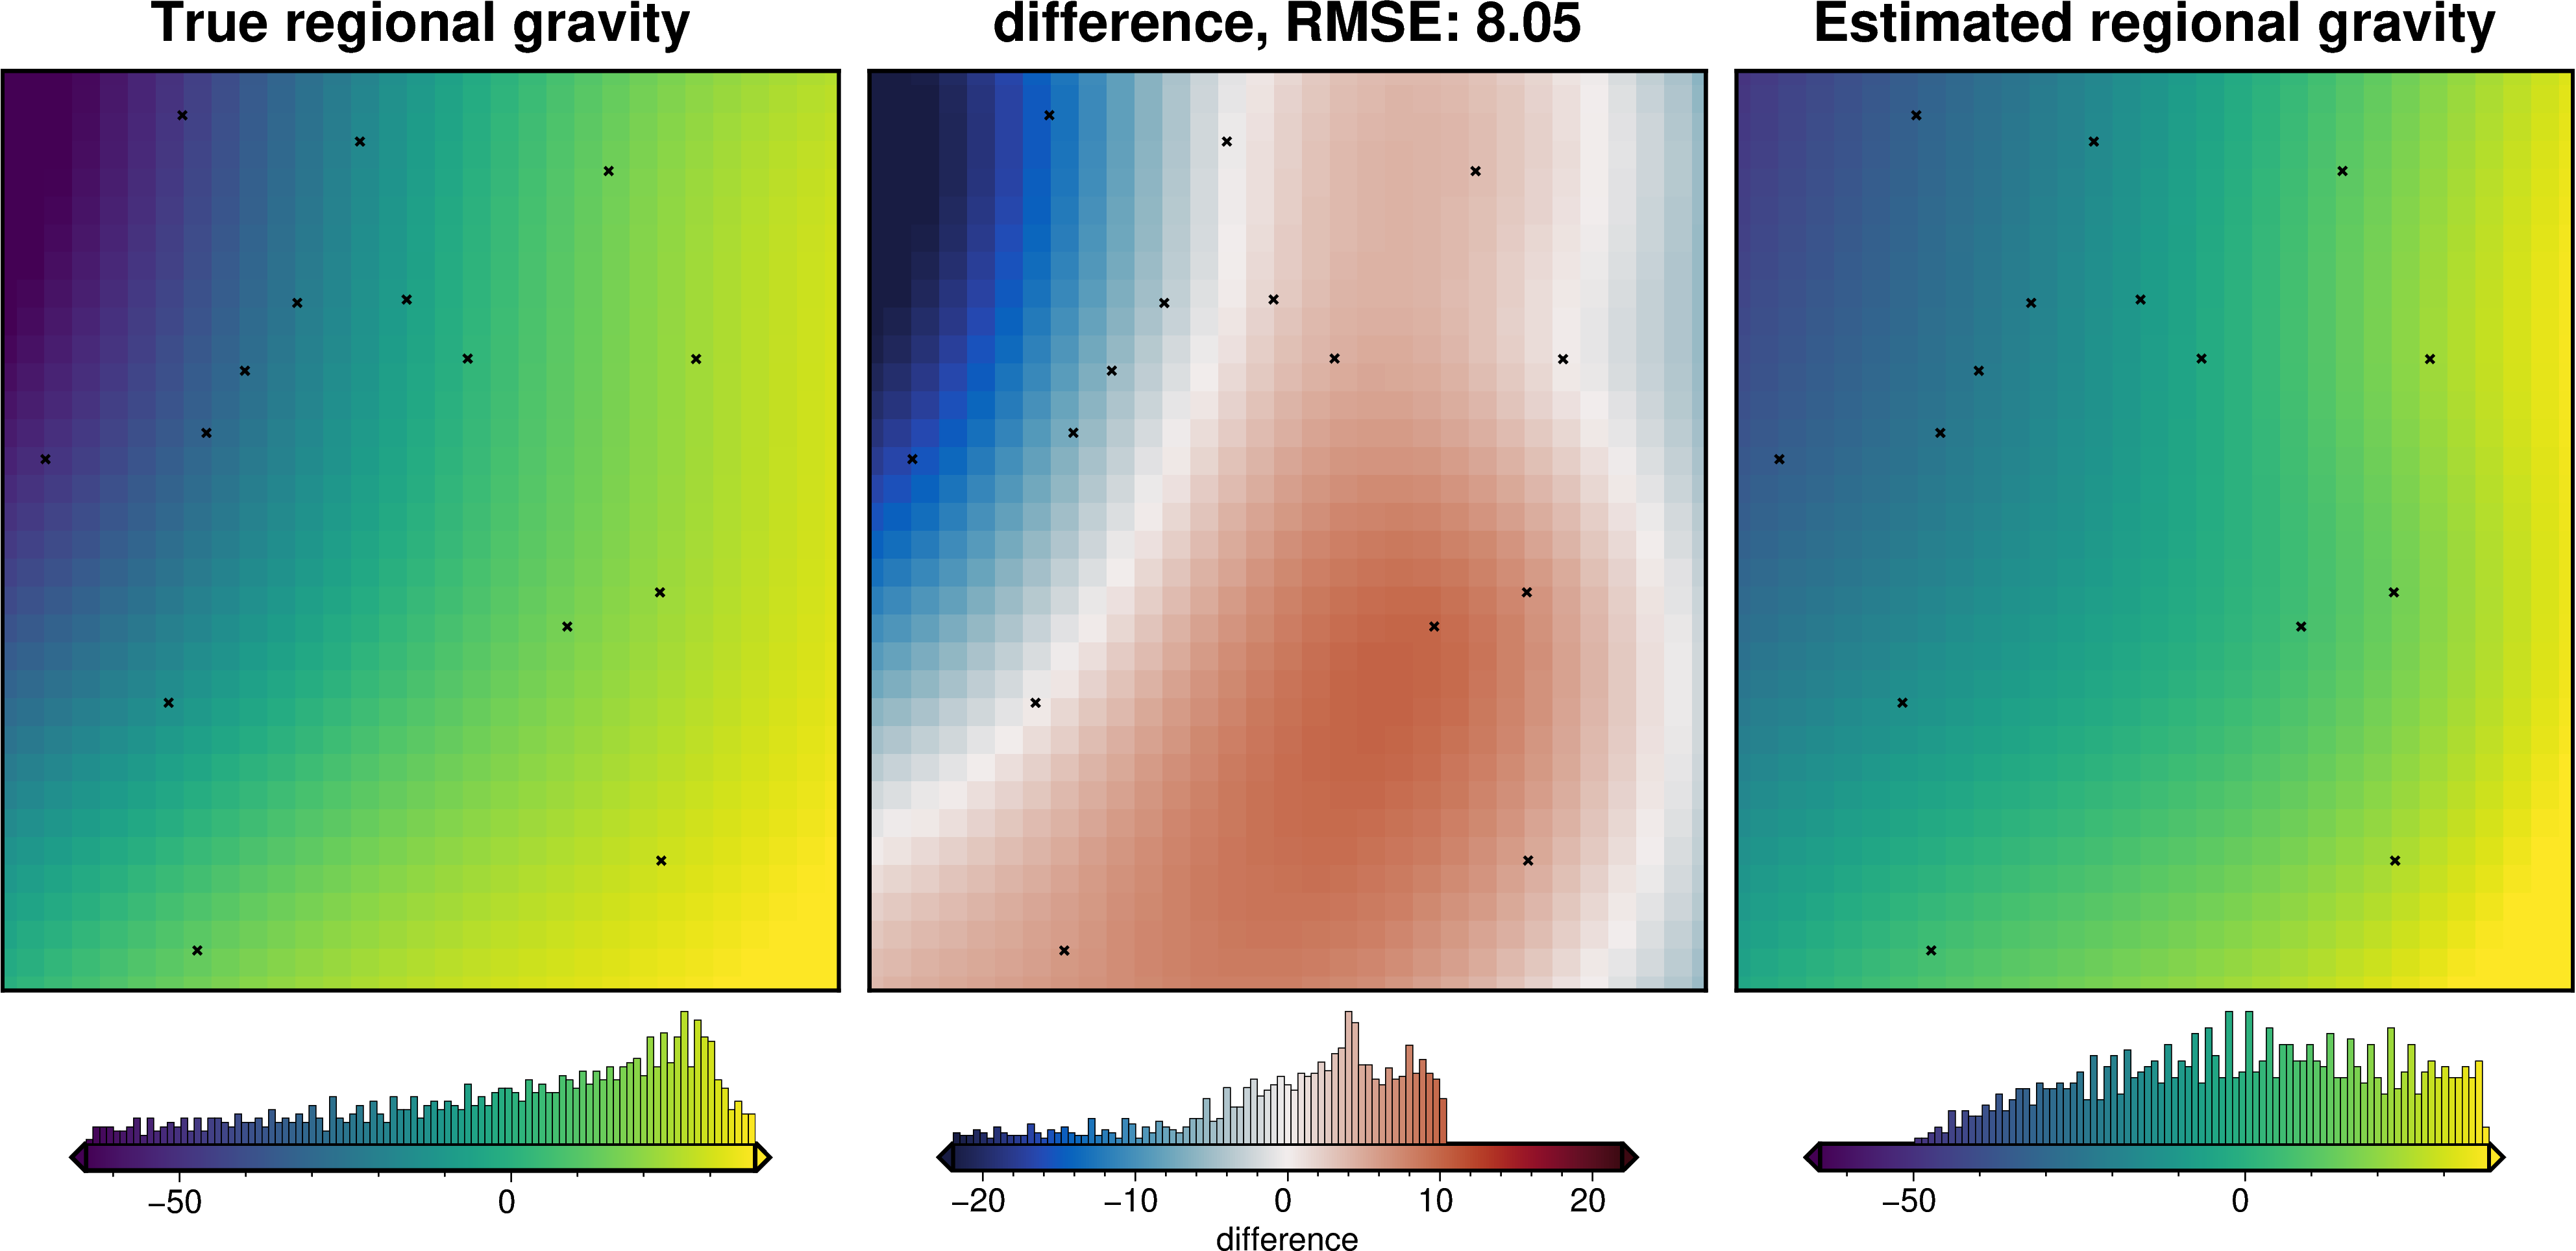

In [18]:
_ = polar_utils.grd_compare(
    grav_grid.moho_grav - np.mean(grav_grid.moho_grav),
    grav_grid.reg - np.mean(grav_grid.reg),
    region=inversion_region,
    plot=True,
    grid1_name="True regional gravity",
    grid2_name="Estimated regional gravity",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    # diff_lims=(-20, 20),
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

# Damping parameter cross validation

In [19]:
# set Python's logging level
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

# set kwargs to pass to the inversion
kwargs = {
    "grav_data_column": "topo_free_disturbance",
    "prism_layer": starting_prisms,
    "deriv_type": "annulus",
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": 0.2,
    "delta_l2_norm_tolerance": 1.004,
    # topographic bounds
    "upper_confining_layer": xr.ones_like(starting_topography),
}

# set which damping parameters to include
dampings = np.logspace(-4, -1, 8)

best_inv_results, best_damping, _, _, scores = cross_validation.grav_optimal_parameter(
    training_data=grav_df[grav_df.test == False],  # noqa: E712
    testing_data=grav_df[grav_df.test == True],  # noqa: E712
    param_to_test=("solver_damping", dampings),
    rmse_as_median=True,
    progressbar=True,
    # plot_grids=True,
    plot_cv=False,
    verbose=True,
    **kwargs,
)

solver_damping values:   0%|          | 0/8 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

INFO:root:solver_damping value: 0.0001 -> Score: 0.3073563688595389
INFO:root:solver_damping value: 0.00026826957952797245 -> Score: 0.05871959735080878
INFO:root:solver_damping value: 0.0007196856730011522 -> Score: 0.024036459522855935
INFO:root:solver_damping value: 0.0019306977288832496 -> Score: 0.022137860227564587
INFO:root:solver_damping value: 0.005179474679231213 -> Score: 0.023832347016703892
INFO:root:solver_damping value: 0.013894954943731374 -> Score: 0.03098052686823216
INFO:root:solver_damping value: 0.03727593720314938 -> Score: 0.18571660119574318
INFO:root:solver_damping value: 0.1 -> Score: 3.3667160140854087
INFO:root:Best score of 0.022137860227564587 with solver_damping=0.0019306977288832496


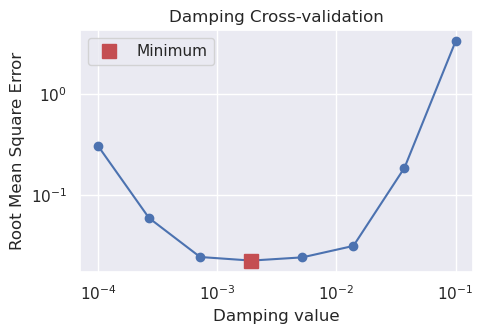

In [20]:
# Compare the scores and the damping values
plotting.plot_cv_scores(
    scores,
    dampings,
    param_name="Damping",
    logx=True,
    logy=True,
)

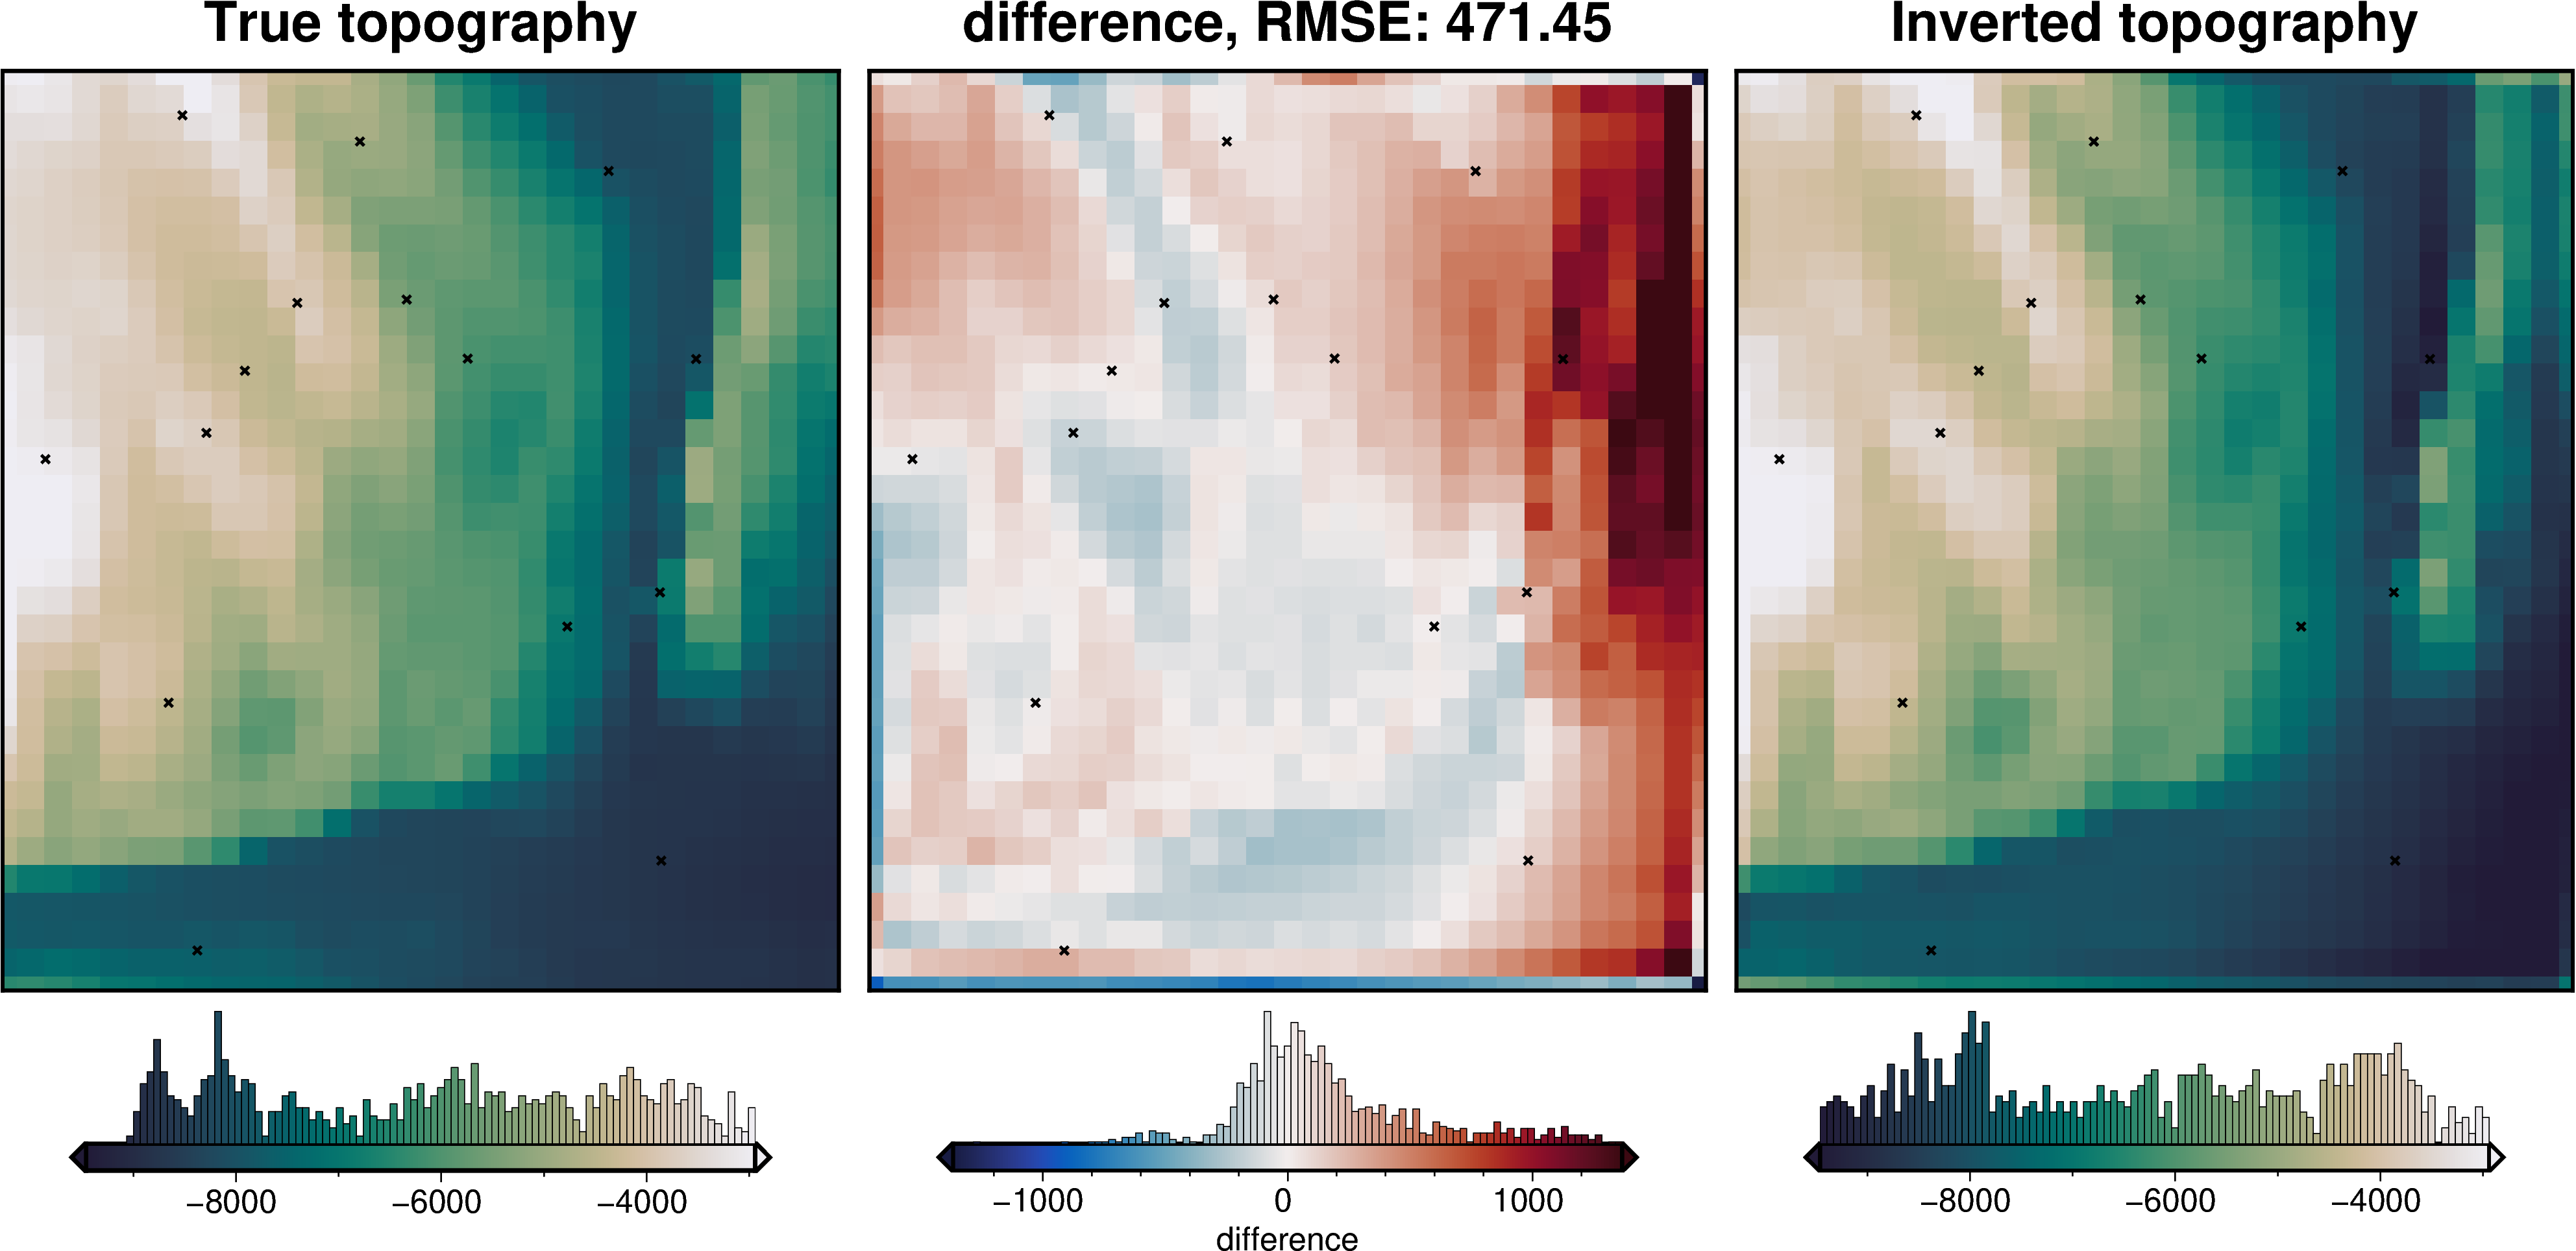

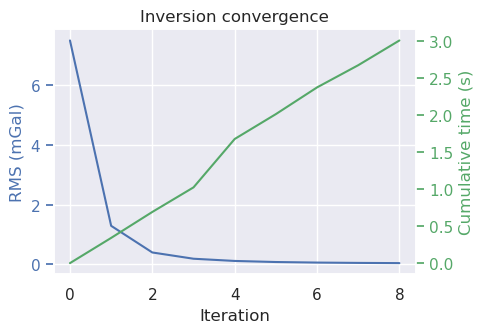

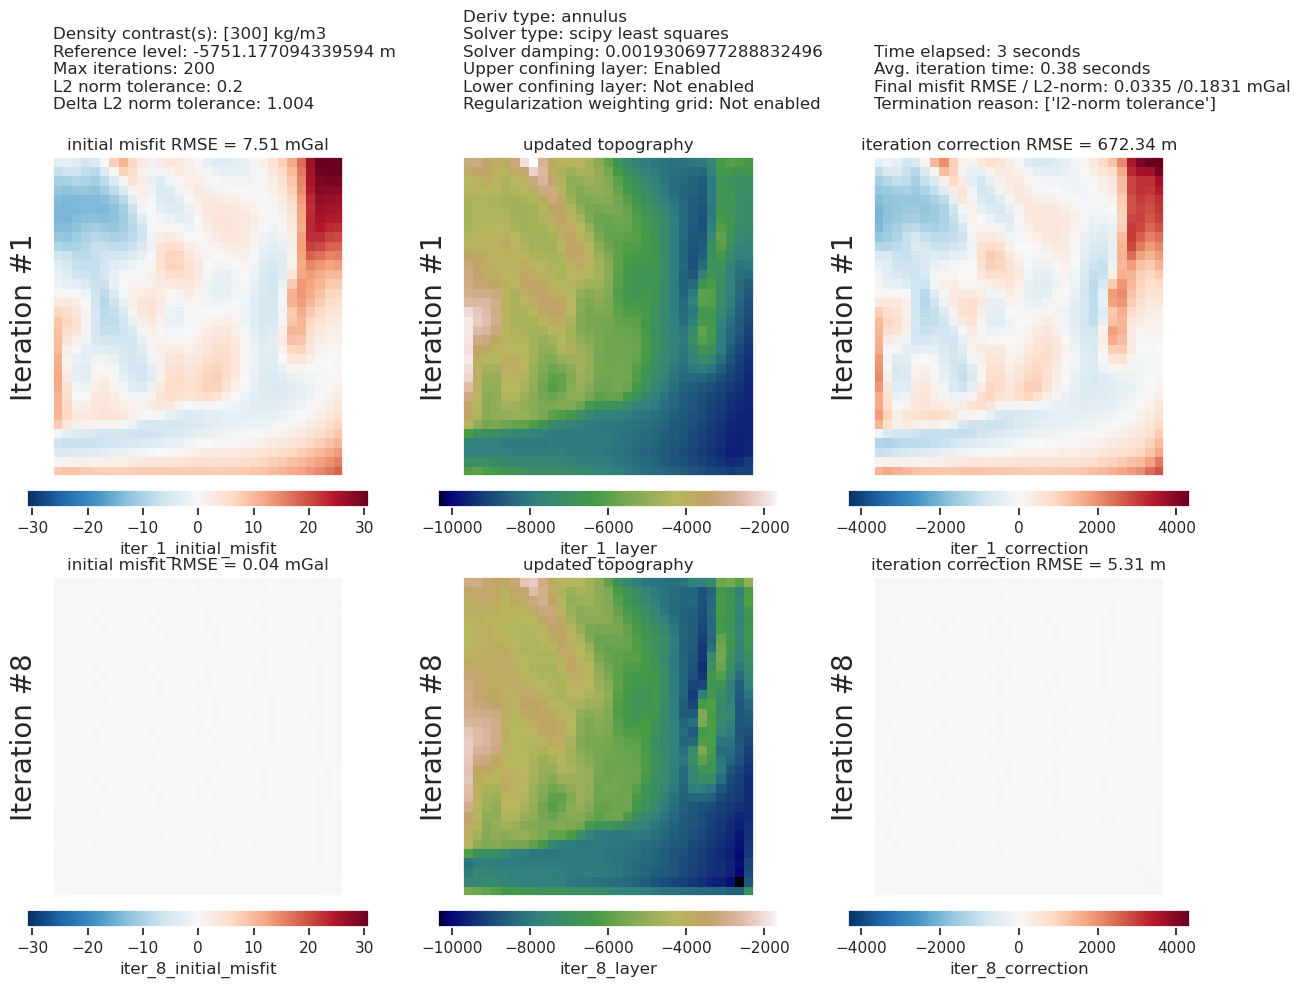

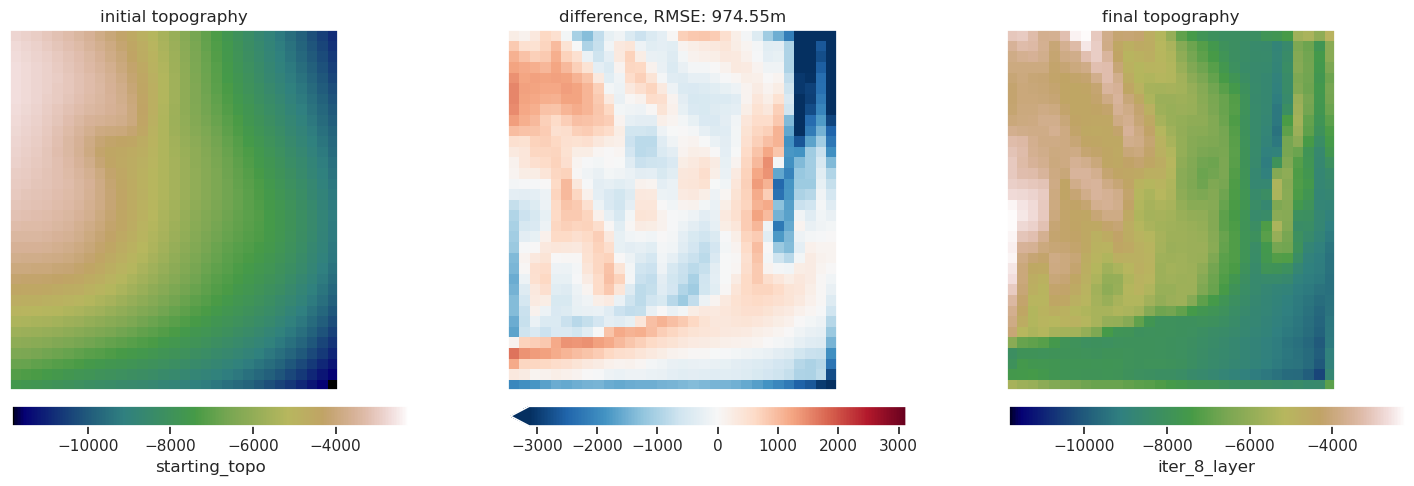

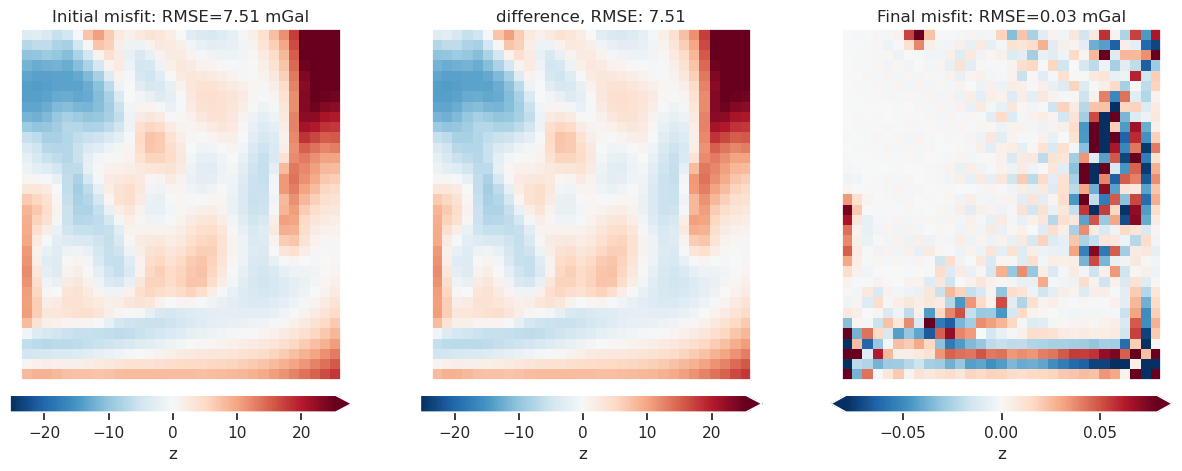

In [21]:
# collect the best results
topo_results, grav_results, parameters, elapsed_time = best_inv_results

plotting.plot_convergence(
    grav_results,
    iter_times=parameters["Iteration times"],
)

plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    data.basement,
    final_topography,
    region=inversion_region,
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

In [22]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 334.67 m


## Adhering to constraints: weighting grid
To force the invesion to adhere to the starting model we need to supply a weighting grid. At each iteration, the `correction grid` is multiplied by this weighting grid to alter the iteration's correction. Therefore, this weighting grid should be ~0 at the constraints, so that they aren't altered from the starting model. These values should increase to ~1 at a distance to allow the inversion to be un-affected at locations far from constraints. 

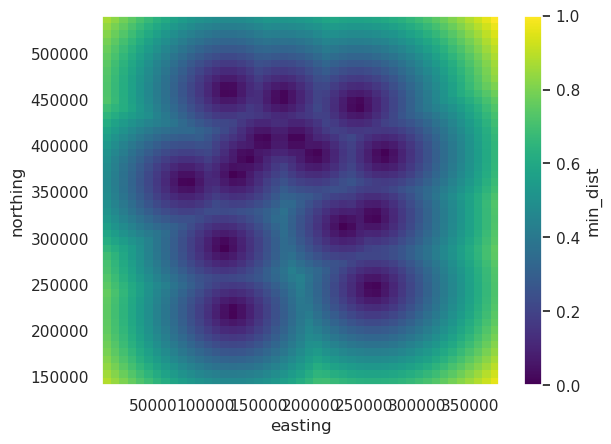

In [23]:
# calculate the distance between each grid cell and the nearest constraint, then
# normalize those values between 0 and 1
weighting_grid = utils.normalized_mindist(
    constraint_points,
    starting_prisms,
    low=0,
    high=1,
)
weighting_grid.plot()

Iteration:   0%|          | 1/200 [00:00<?, ?it/s]

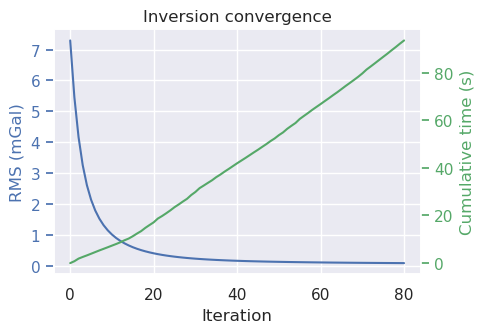

In [25]:
logger = logging.getLogger()
logger.setLevel(logging.WARNING)

kwargs = {
    # needed to create starting topography
    "starting_topography": starting_topography,
    # needed to create starting prisms model
    "starting_prisms_kwargs": {
        "density_contrast": density_contrast,
        "zref": zref,
    },
    # needed to calculate misfit
    "grav_data_column": "topo_free_disturbance",
    # needed to separate regional
    "regional_grav_kwargs": {
        "regional_method": "constraints",
        "constraints_df": constraint_points,
        "dampings": constraints_dampings,
    },
    # inversion parameters
    "deriv_type": "annulus",
    "solver_damping": best_damping,
    "max_iterations": 200,
    "l2_norm_tolerance": 0.2,
    "delta_l2_norm_tolerance": 1.005,
    "apply_weighting_grid": True,
    "weighting_grid": weighting_grid,
    "plot_convergence": True,
    "upper_confining_layer": xr.ones_like(starting_topography),
}

# run the inversion workflow, including re-creating the prism layer with the
# optimal zref and density
results = inversion.run_inversion_workflow(
    grav_df=grav_df,
    create_starting_prisms=True,
    calculate_regional_misfit=True,
    **kwargs,
)

# collect the results
topo_results, grav_results, parameters, elapsed_time = results

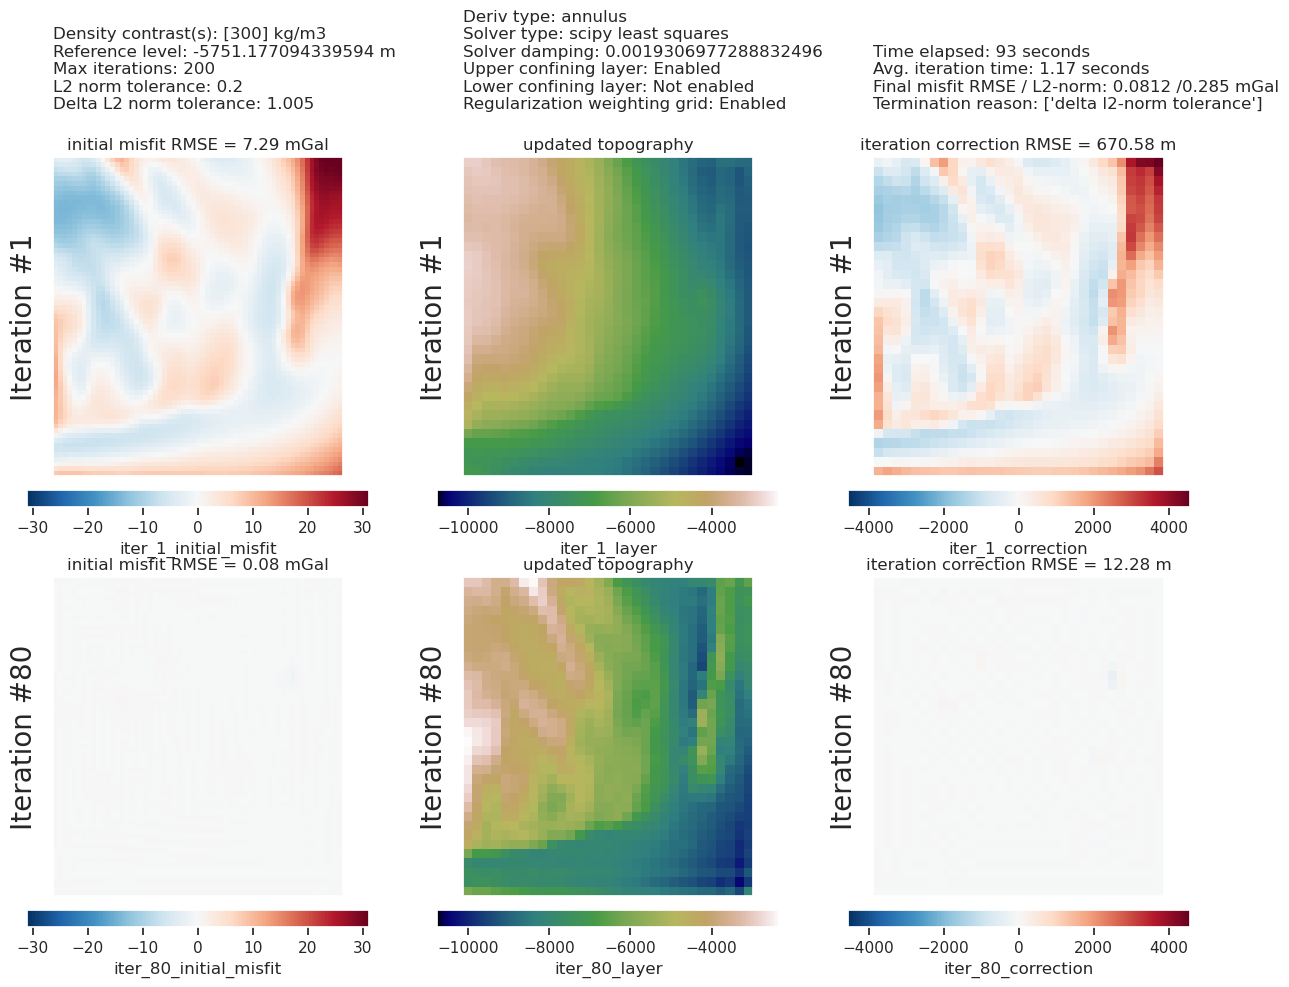

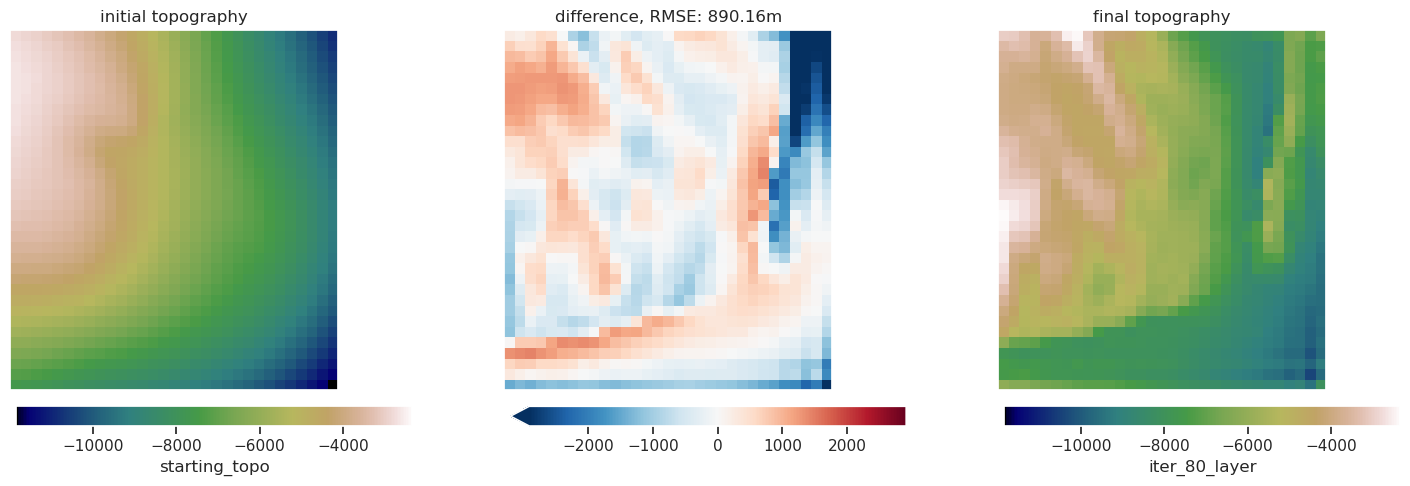

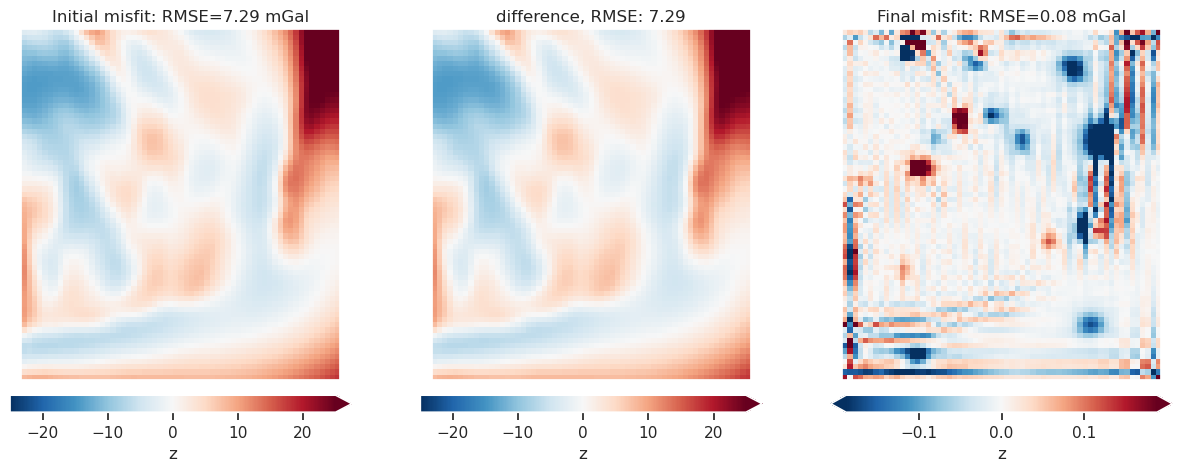

In [26]:
plotting.plot_inversion_results(
    grav_results,
    topo_results,
    parameters,
    grav_region=inversion_region,
    iters_to_plot=2,
    plot_iter_results=True,
    plot_topo_results=True,
    plot_grav_results=True,
)

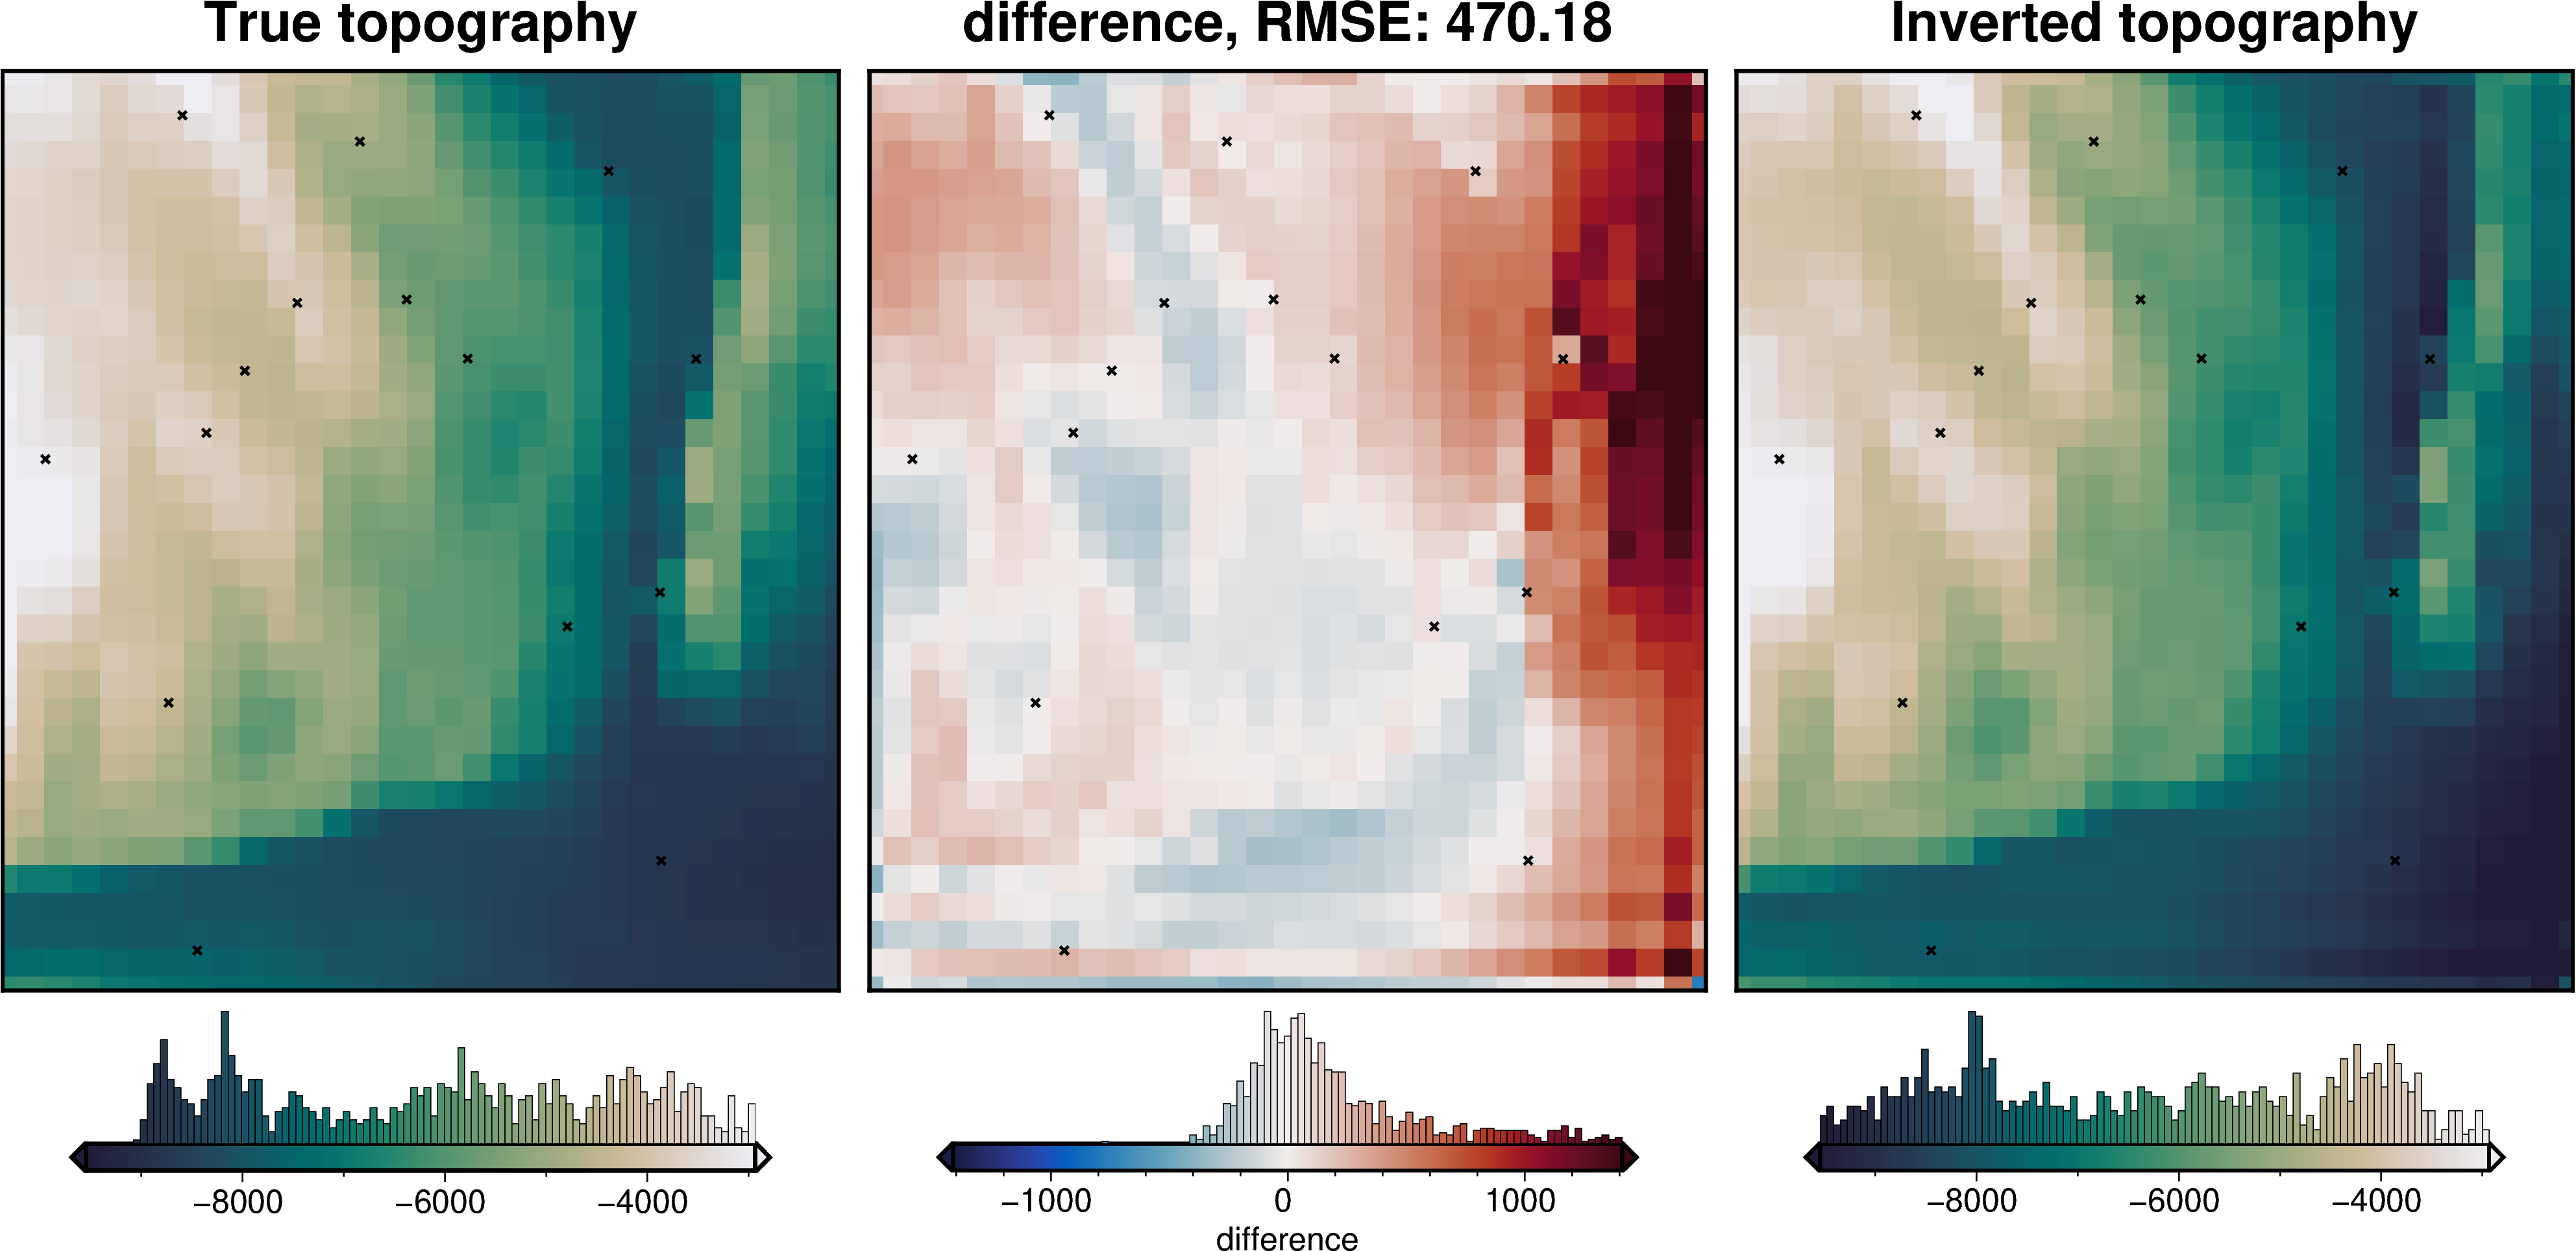

In [27]:
final_topography = topo_results.set_index(["northing", "easting"]).to_xarray().topo

_ = polar_utils.grd_compare(
    data.basement,
    final_topography,
    # plot_type="xarray",
    plot=True,
    grid1_name="True topography",
    grid2_name="Inverted topography",
    robust=True,
    hist=True,
    inset=False,
    verbose="q",
    title="difference",
    grounding_line=False,
    reverse_cpt=True,
    cmap="rain",
    region=inversion_region,
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="x.15c",
)

In [28]:
# sample the inverted topography at the constraint points
constraint_points = utils.sample_grids(
    constraint_points,
    final_topography,
    "inverted_topography",
    coord_names=("easting", "northing"),
)

rmse = utils.rmse(constraint_points.upward - constraint_points.inverted_topography)
print(f"RMSE: {rmse:.2f} m")

RMSE: 135.43 m
